
# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image

import os
import xml.etree.ElementTree as ET

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential
from scipy.io import loadmat
import pandas as pd
import h5py


# Data Preparation

In [39]:
#Reading the meta data file
mat_train = loadmat('car_devkit/devkit/cars_train_annos.mat')
mat_test = loadmat('car_devkit/devkit/cars_test_annos.mat')
meta = loadmat('car_devkit/devkit/cars_meta.mat')

In [40]:
#saving the names of the vehicle label
labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])


In [41]:
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    bbox_x1 = example[0][0][0]
    bbox_x2 = example[1][0][0]
    bbox_y1 = example[2][0][0]
    bbox_y2 = example[3][0][0]
    train.append((image,bbox_x1, bbox_x2, bbox_y1, bbox_y2, label))
    

In [42]:
test = list()
for example in mat_test['annotations'][0]:
    image = example[-1][0]
    test.append(image)

validation_size = int(len(train) * 0.10)
test_size = int(len(train) * 0.20)

validation = train[:validation_size].copy()
np.random.shuffle(validation)
train = train[validation_size:]

test = train[:test_size].copy()
np.random.shuffle(test)
train = train[test_size:]

In [46]:
test_path = "stanford car/cars_test/cars_test/"
train_path = "stanford car/cars_train/cars_train/"
org_path = "stanford car/cars_train/cars_train/"
org_path_test = "stanford car/cars_test/cars_test/"

In [7]:
with open('stanford car/cars_data.csv', 'w+') as f:
    [f.write('TRAIN,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in train]
    [f.write('VALIDATION,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in validation]
    [f.write('TEST,%s,%s,%s\n' %(test_path, org_path_test, img)) for img,_,_,_,_,_ in test]# encoding:utf8

In [2]:

data_met = pd.read_csv('stanford car/cars_data.csv')

In [3]:
data_met.describe()

,ymin,xmax,ymax
count,6516.000000,6516.000000,6516.000000
mean,109.036219,637.808625,416.864794
std,106.036613,410.210025,272.715397
min,1.000000,76.000000,47.000000
25%,42.000000,392.000000,248.000000
50%,80.000000,569.000000,361.000000
75%,139.000000,747.250000,479.000000
max,1508.000000,5205.000000,3389.000000


In [4]:
# creating training data set
train_data_met = data_met.dropna()
train_data_met

,type,org_path,path,xmin,ymin,xmax,ymax,label,img
0,TRAIN,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg
1,TRAIN,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg
2,TRAIN,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg
3,TRAIN,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg
4,TRAIN,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram C/V Cargo Van Minivan 2012,02447.jpg
...,...,...,...,...,...,...,...,...,...
6511,VALIDATION,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/00223.jpg,42,115.0,299.0,288.0,FIAT 500 Abarth 2012,00223.jpg
6512,VALIDATION,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/00408.jpg,49,76.0,343.0,266.0,Audi TT Hatchback 2011,00408.jpg
6513,VALIDATION,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/00231.jpg,73,109.0,606.0,374.0,Ford F-450 Super Duty Crew Cab 2012,00231.jpg
6514,VALIDATION,stanford car/cars_train/cars_train/,stanford car/cars_train/cars_train/00295.jpg,150,114.0,524.0,433.0,Buick Enclave SUV 2012,00295.jpg


In [5]:
#removing '/' before creating folder as it is a problem to give paths
train_data_met['label'] = train_data_met['label'].str.replace('/','')
brand = train_data_met['label'].unique()
len(brand)

C:\Users\z004kdpf\AppData\Local\Temp\ipykernel_124200\2435065217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['label'] = train_data_met['label'].str.replace('/','')


196

# **Data Pre-processing - Cropping the car out of every image**
## localisation

In [12]:
#creating a new folder to store cropped car images
os.mkdir('stanford car/data')
for brands in brand:
    os.mkdir('stanford car/data/' + brands)
print('Created {} folders to store cropped images of the different types.'.format(len(os.listdir('stanford car/data'))))

Created 196 folders to store cropped images of the different types.


In [14]:
for i in range(0,6516):
    a =train_data_met['path'][i]
    xmin = int(train_data_met['xmin'][i])
    ymin = int(train_data_met['ymin'][i])
    xmax = int(train_data_met['xmax'][i])
    ymax = int(train_data_met['ymax'][i])
    print(i,a,xmin,xmax,ymin,ymax)
    img = Image.open(a)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['img'][i]
    img.save('stanford car/data/' + train_data_met['label'][i] + '/'+filename)

0 stanford car/cars_train/cars_train/02443.jpg 74 617 62 411
1 stanford car/cars_train/cars_train/02444.jpg 70 737 60 541
2 stanford car/cars_train/cars_train/02445.jpg 30 743 99 427
3 stanford car/cars_train/cars_train/02446.jpg 60 839 126 578
4 stanford car/cars_train/cars_train/02447.jpg 64 341 58 177
5 stanford car/cars_train/cars_train/02448.jpg 3 1017 226 621
6 stanford car/cars_train/cars_train/02449.jpg 61 595 150 378
7 stanford car/cars_train/cars_train/02450.jpg 51 595 99 382
8 stanford car/cars_train/cars_train/02451.jpg 29 269 11 159
9 stanford car/cars_train/cars_train/02452.jpg 20 249 44 161
10 stanford car/cars_train/cars_train/02453.jpg 24 450 61 306
11 stanford car/cars_train/cars_train/02454.jpg 50 605 167 392
12 stanford car/cars_train/cars_train/02455.jpg 79 563 97 353
13 stanford car/cars_train/cars_train/02456.jpg 40 224 38 155
14 stanford car/cars_train/cars_train/02457.jpg 126 885 227 551
15 stanford car/cars_train/cars_train/02458.jpg 25 520 57 297
16 stanford 

# **Using Keras ImageDataGenerator to rescale and augment data, and split it into Training and Validation sets**

In [6]:
train_directory = "stanford car/data"
#Data Augmentation and train-val split
#keras_preprocessing.image  ImageDataGenerator is used to generate tensor of image with realtime data augmentation.
#rescale helps to reduce the parameter
#shear range determines the maximum extent to which an object or an image can be distorted along a particular axis.
#zoom range is the range of random zoom
sd_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
)

In [21]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
#Loading train data
train_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading val data
val_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5293 images belonging to 196 classes.
Found 1223 images belonging to 196 classes.


In [18]:
# Wrap the DirectoryIterator with a tf.data.Dataset object
val_dataset = tf.data.Dataset.from_generator(
    lambda: val_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,196), dtype=tf.int32)
    )
)

# Repeat the dataset for the specified number of epochs
val_dataset = val_dataset.repeat(150)

In [10]:
1223  /64


19.109375

# **Running a Random Generator to visualize a few images post Pre-processing and Augmentation**

Found 5293 images belonging to 196 classes.


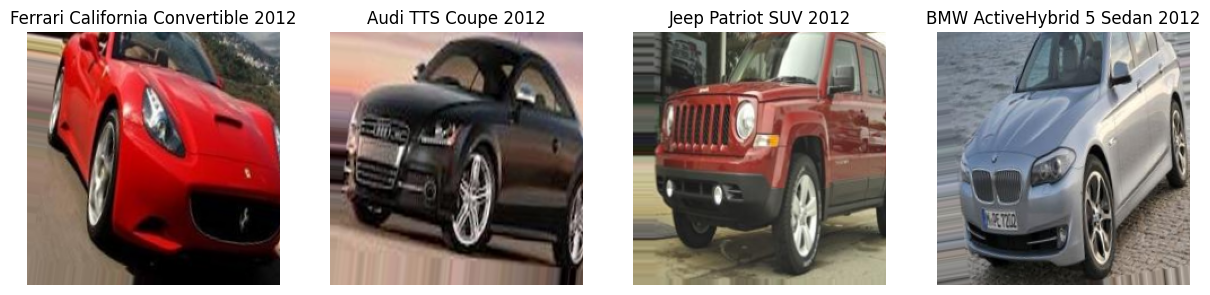

In [11]:
#Code referenced from https://github.com/renxzen/stanfordDogs/blob/main/stanfordDogs.ipynb

rand_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

plt.figure(figsize=(15,10))
for i in range(4):
    rand_img = next(rand_gen)
    name = list(rand_gen.class_indices.keys())[list(rand_gen.class_indices.values()).index(np.argmax(rand_img[1]))]
    plt.subplot(1,4,i+1)
    plt.title(name)
    plt.imshow(rand_img[0].reshape(224, 224, 3))
    plt.axis('off')

# **Training the ResNet50V2 pre-trained model**

In [23]:
# ResNet50V2 Pre-trained Model
# https://keras.io/api/applications/

base_model_rsn = keras.applications.ResNet50V2(
    weights = 'imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

#Architecture referenced from https://github.com/renxzen/stanfordDogs/blob/main/stanfordDogs.ipynb
x = keras.layers.Flatten()(base_model_rsn.output)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

out = keras.layers.Dense(196, activation='softmax')(x)

base_model_rsn.trainable = False
for layer in base_model_rsn.layers:
    layer.trainable = False

In [24]:
model_rsn = keras.Model(base_model_rsn.input, out)

#Compiling the model
model_rsn.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [14]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [26]:
#Training the model
history_rsn = model_rsn.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=150,
    verbose=1,
    callbacks = callbacks
)

Epoch 1/150
80/80 [==============================] - ETA: 0s - loss: 5.7591 - accuracy: 0.0535
Epoch 1: val_accuracy improved from 0.00000 to 0.06641, saving model to training
80/80 [==============================] - 207s 3s/step - loss: 5.7591 - accuracy: 0.0535 - val_loss: 9.7996 - val_accuracy: 0.0664
Epoch 2/150
80/80 [==============================] - ETA: 0s - loss: 4.5926 - accuracy: 0.1303
Epoch 2: val_accuracy improved from 0.06641 to 0.12891, saving model to training
80/80 [==============================] - 207s 3s/step - loss: 4.5926 - accuracy: 0.1303 - val_loss: 5.6614 - val_accuracy: 0.1289
Epoch 3/150
80/80 [==============================] - ETA: 0s - loss: 3.9660 - accuracy: 0.2086
Epoch 3: val_accuracy improved from 0.12891 to 0.22656, saving model to training
80/80 [==============================] - 208s 3s/step - loss: 3.9660 - accuracy: 0.2086 - val_loss: 4.6379 - val_accuracy: 0.2266
Epoch 4/150
80/80 [==============================] - ETA: 0s - loss: 3.5303 - accu

In [90]:
model.save("ml-model-deployment/150e.model", save_format="h5")

In [108]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [29]:
model_rsn.save("novalcarresnet50v2l_150e.model", save_format="h5")

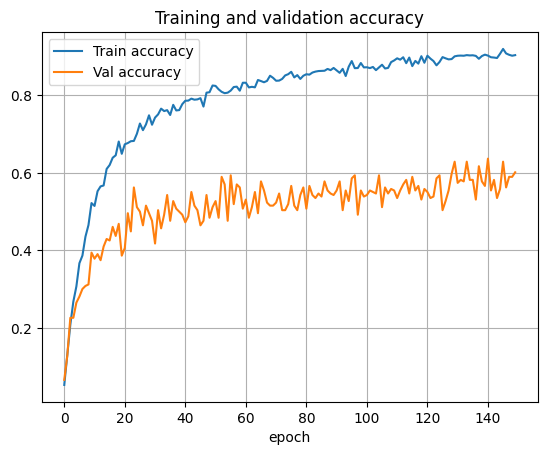

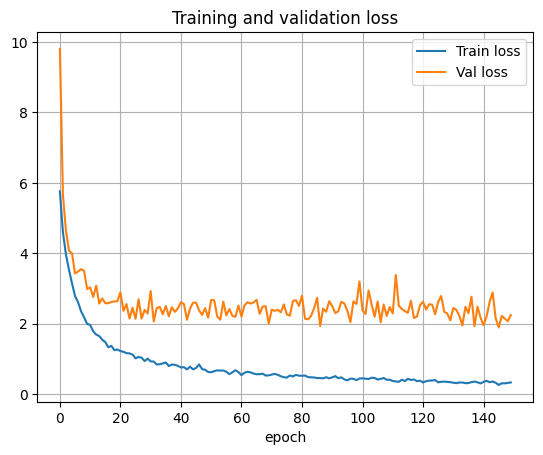

In [27]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()

plt.plot(history_rsn.history['accuracy'], label='Train accuracy')
plt.plot(history_rsn.history['val_accuracy'], label='Val accuracy')
plt.legend(loc=0)
plt.title('Training and validation accuracy')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

plt.plot(history_rsn.history['loss'], label='Train loss')
plt.plot(history_rsn.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

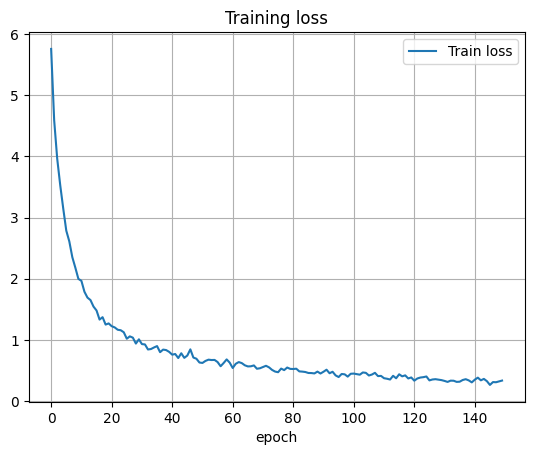

In [28]:
#Plotting graphs to visualize the progression of training and validation accuracy and loss curves
fig = plt.figure()



plt.plot(history_rsn.history['loss'], label='Train loss')

plt.legend(loc=0)
plt.title('Training loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [62]:
model_rsn = keras.models.load_model('carresnet50v2l_150e.model')

In [30]:
model_rsn_noval = keras.models.load_model('novalcarresnet50v2l_150e.model')

In [64]:
loss, acc = model_rsn.evaluate(val_gen) #evaluating ResNet50V2 model on new validation set
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

20/20 [==============================] - 36s 2s/step - loss: 2.2676 - accuracy: 0.5437
val_loss: 2.2675986289978027, val_acc:54.37%


In [65]:
loss, acc = model_rsn_noval.evaluate(val_gen) #evaluating ResNet50V2 model on new validation set
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

20/20 [==============================] - 35s 2s/step - loss: 2.4290 - accuracy: 0.5527
val_loss: 2.429030179977417, val_acc:55.27%


# setting the test data

In [47]:
with open('stanford car/cars_data_test.csv', 'w+') as f:
    [f.write('TEST,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(test_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in test]


In [49]:
data_met_T = pd.read_csv('stanford car/cars_data_test.csv')
data_met_T

,type,org_path,path,xmin,ymin,xmax,ymax,label,img
0,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01587.jpg,32,162,2577,1730,Nissan Juke Hatchback 2012,01587.jpg
1,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01456.jpg,35,63,464,331,GMC Yukon Hybrid SUV 2012,01456.jpg
2,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01642.jpg,13,122,480,286,Honda Odyssey Minivan 2012,01642.jpg
3,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01824.jpg,55,31,341,238,Toyota Sequoia SUV 2012,01824.jpg
4,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/00985.jpg,79,64,281,190,BMW X3 SUV 2012,00985.jpg
...,...,...,...,...,...,...,...,...,...
1623,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01402.jpg,41,60,226,165,GMC Terrain SUV 2012,01402.jpg
1624,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01749.jpg,7,52,130,129,MINI Cooper Roadster Convertible 2012,01749.jpg
1625,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01099.jpg,246,681,1344,1069,Bugatti Veyron 16.4 Convertible 2009,01099.jpg
1626,TEST,stanford car/cars_test/cars_test/,stanford car/cars_train/cars_train/01737.jpg,27,41,635,459,Hyundai Tucson SUV 2012,01737.jpg


In [50]:
#removing '/' before creating folder as it is a problem to give paths
data_met_T['label'] = data_met_T['label'].str.replace('/','')
brand_t = data_met_T['label'].unique()
len(brand_t)

196

In [63]:
#creating a new folder to store cropped car images
os.mkdir('stanford car/test_data')
for brands in brand_t:
    os.mkdir('stanford car/test_data/' + brands)
print('Created {} folders to store test images of the different types.'.format(len(os.listdir('stanford car/test_data'))))

Created 196 folders to store test images of the different types.


In [64]:
for i in range(0,1627):
    a =data_met_T['path'][i]
    # xmin = int(train_data_met['xmin'][i])
    # ymin = int(train_data_met['ymin'][i])
    # xmax = int(train_data_met['xmax'][i])
    # ymax = int(train_data_met['ymax'][i])
    print(i,a)
    img = Image.open(a)
    #img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['img'][i]
    img.save('stanford car/test_data/' + data_met_T['label'][i] + '/'+filename)

0 stanford car/cars_train/cars_train/01587.jpg
1 stanford car/cars_train/cars_train/01456.jpg
2 stanford car/cars_train/cars_train/01642.jpg
3 stanford car/cars_train/cars_train/01824.jpg
4 stanford car/cars_train/cars_train/00985.jpg
5 stanford car/cars_train/cars_train/02369.jpg
6 stanford car/cars_train/cars_train/01794.jpg
7 stanford car/cars_train/cars_train/02248.jpg
8 stanford car/cars_train/cars_train/01296.jpg
9 stanford car/cars_train/cars_train/01718.jpg
10 stanford car/cars_train/cars_train/00958.jpg
11 stanford car/cars_train/cars_train/02381.jpg
12 stanford car/cars_train/cars_train/01860.jpg
13 stanford car/cars_train/cars_train/01717.jpg
14 stanford car/cars_train/cars_train/01832.jpg
15 stanford car/cars_train/cars_train/02399.jpg
16 stanford car/cars_train/cars_train/00828.jpg
17 stanford car/cars_train/cars_train/01843.jpg
18 stanford car/cars_train/cars_train/01075.jpg
19 stanford car/cars_train/cars_train/01940.jpg
20 stanford car/cars_train/cars_train/01001.jpg
21

In [71]:
test_directory = "stanford car/test_data/"
sd_gen_t = ImageDataGenerator(
    rescale = 1./255,
)

test_gen = sd_gen_t.flow_from_directory(
    test_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1627 images belonging to 196 classes.


In [68]:
loss_test, acc_test = model_rsn.evaluate(test_gen) #evaluating ResNet50V2 model on fresh test set
print(f"test_loss: {loss_test}, test_acc:{round(acc_test*100,2)}%")

51/51 [==============================] - 49s 965ms/step - loss: 5.2543 - accuracy: 0.3141
test_loss: 5.254340171813965, test_acc:31.41%


In [69]:
# Get the class labels
class_labels = list(test_gen.class_indices.keys())

# Retrieve the filenames and labels
filenames = test_gen.filenames
labels = test_gen.labels

# Iterate over the filenames and corresponding labels
for filename, label in zip(filenames, labels):
    # Retrieve the corresponding class label
    class_label = class_labels[label]

    # Print the filename and the associated class label
    print(f"Filename: {filename}, Class Label: {class_label}")

Filename: AM General Hummer SUV 2000\02457.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02763.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02847.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03147.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03285.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03286.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03505.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03529.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03573.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03701.jpg, Class Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03924.jpg, Class Label: AM General Hummer SUV 2000
Filename: Acura Integra Type R 2

In [107]:
class_labels[51]

'Cadillac Escalade EXT Crew Cab 2007'

In [72]:
# Get the class labels
class_labels = list(test_gen.class_indices.keys())

# Retrieve the filenames, true labels, and predicted labels
filenames = test_gen.filenames
labels = test_gen.labels

# Predict labels for the test set
predictions = model_rsn.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

# Iterate over the filenames, true labels, and predicted labels
for filename, true_label, predicted_label in zip(filenames, labels, predicted_labels):
    # Retrieve the corresponding class labels
    true_class_label = class_labels[true_label]
    predicted_class_label = class_labels[predicted_label]

    # Print the filename, true label, and predicted label
    print(f"Filename: {filename}, True Label: {true_class_label}, Predicted Label: {predicted_class_label}")

51/51 [==============================] - 50s 971ms/step
Filename: AM General Hummer SUV 2000\02457.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02763.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\02847.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03147.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03285.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03286.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: AM General Hummer SUV 2000
Filename: AM General Hummer SUV 2000\03505.jpg, True Label: AM General Hummer SUV 2000, Predicted Label: Jeep Wrangler SUV 2012
Filename: AM General Hum